Reference: https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/    
https://stackabuse.com/python-for-nlp-working-with-the-gensim-library-part-2/

In [1]:
import pandas as pd
import numpy as np
import re
import os
from os import path

# Gensim Package
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

#spacy for lemmatization
import spacy

# Plotting package
import matplotlib.pyplot as plt

#logging
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(mmessage)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

en_stop = set(nltk.corpus.stopwords.words('english'))
en_stop= en_stop.union(('well','half','also','year','shall','whereas','note','going','must','point','five','said','nam','viet','shall',\
                       'per','many','much','either','long','ifor','upon','first','man','men','ever','thus','twenty','aforesaid','within','fourth',\
                       'would','state','government','union','unite','herewith','world','country','public','america','whilst',\
                       'tonight','today','percent','henceforth','likewise','program','pre','people','american','new',\
                       'congress','make','say','number','united','time','one','may','nation','let','could'))

In [2]:
# Load files from directory
root_folder = "topicmodel_speeches"
files = os.listdir(root_folder)

## Read the speeches from the text file and load into a list

In [3]:
#load speeches into a list
speeches = [] 
file_names = []
for file in files:
    with open(path.join(root_folder, file), 'r') as file_desc:
       text = file_desc.read()
       speeches.append(text)
       file_names.append(file)


## Extract President Name and Date of Speech by parsing the file name
example :  file name: "1789-10-03 George Washington.txt" - first part of file name is date of speech and second part is name of president

In [4]:
def extract_metaData(file_names):
    date_of_speech =[]
    president_names = []
    
    for file in file_names:
        data = file.replace('.txt','')
        data = data.split(' ',1)
        
        date_of_speech.append(data[0])
        president_names.append(data[1])
        print("\n",data[0]," ",data[1])

    return date_of_speech, president_names
    
# call the extract_metaData function to parse the file name and extract date of speech and name of president    
date_of_speech, president_names = extract_metaData(file_names)    


 1789-04-30   George Washington

 1789-10-03   George Washington

 1790-01-08   George Washington

 1790-12-08   George Washington

 1790-12-29   George Washington

 1791-10-25   George Washington

 1792-04-05   George Washington

 1792-11-06   George Washington

 1792-12-12   George Washington

 1793-03-04   George Washington

 1793-04-22   George Washington

 1793-12-03   George Washington

 1794-08-07   George Washington

 1794-09-25   George Washington

 1794-11-19   George Washington

 1795-07-10   George Washington

 1795-12-08   George Washington

 1796-03-30   George Washington

 1796-08-29   George Washington

 1796-09-19   George Washington

 1796-12-07   George Washington

 1797-03-04   John Adams

 1797-05-16   John Adams

 1797-11-22   John Adams

 1798-03-23   John Adams

 1798-12-08   John Adams

 1799-12-03   John Adams

 1799-12-19   John Adams

 1800-05-21   John Adams

 1800-11-22   John Adams

 1801-03-04   Thomas Jefferson

 1801-07-12   Thomas Jefferson

 1801-12

 1987-12-10   Ronald Wilson Reagan

 1988-01-25   Ronald Wilson Reagan

 1988-05-31   Ronald Wilson Reagan

 1988-08-15   Ronald Wilson Reagan

 1988-08-18   George H. W. Bush

 1988-09-25   George H. W. Bush

 1988-09-26   Ronald Wilson Reagan

 1988-11-11   Ronald Wilson Reagan

 1988-12-16   Ronald Wilson Reagan

 1989-01-11   Ronald Wilson Reagan

 1989-01-20   George H. W. Bush

 1989-02-09   George H. W. Bush

 1989-05-12   George H. W. Bush

 1989-12-20   George H. W. Bush

 1990-01-31   George H. W. Bush

 1990-07-26   George H. W. Bush

 1990-08-08   George H. W. Bush

 1990-09-11   George H. W. Bush

 1990-10-01   George H. W. Bush

 1990-10-02   George H. W. Bush

 1991-01-16   George H. W. Bush

 1991-01-29   George H. W. Bush

 1991-02-27   George H. W. Bush

 1991-03-06   George H. W. Bush

 1991-07-31   George H. W. Bush

 1992-01-28   George H. W. Bush

 1992-08-20   George H. W. Bush

 1992-10-11   George H. W. Bush

 1992-12-04   George H. W. Bush

 1992-12-15   Georg

In [5]:
print("\n",date_of_speech[21],president_names[21],"\n",speeches[21][0:100])
print("\n",date_of_speech[80],president_names[80],"\n",speeches[80][0:100])
print("\n",date_of_speech[190],president_names[190],"\n",speeches[190][0:100])


 1797-03-04 John Adams 
 When it was first perceived in early times that no middle course for America remained between unlimi

 1820-11-14 James Monroe 
 Fellow Citizens of the Senate and of the House of Representatives: In communicating to you a just vi

 1903-12-07 Theodore Roosevelt 
 To the Senate and House of Representatives: The country is to be congratulated on the amount of subs


In [6]:
df = pd.DataFrame()
df['Date']  = pd.Series(date_of_speech)
df['Name'] = pd.Series(president_names)
df['Speech'] = pd.Series(speeches)

In [7]:
df.sample(50)

,Date,Name,Speech
495,1982-01-26,Ronald Wilson Reagan,Mr. Speaker Mr. President distinguished Member...
100,1833-03-04,Andrew Jackson,Fellow citizens: The will of the American peop...
75,1817-03-03,James Madison,To the House of Representatives of the United ...
536,1988-08-15,Ronald Wilson Reagan,Madam Chairman delegates to the convention and...
521,1985-05-05,Ronald Wilson Reagan,Chancellor Kohl and honored guests this painfu...
90,1827-12-04,John Quincy Adams,Fellow Citizens of the Senate and of the House...
358,1963-12-17,Lyndon Baines Johnson,Mr. President Mr. Secretary General distinguis...
333,1961-11-11,John Fitzgerald Kennedy,General Gavan Mr. Gleason members of the milit...
601,2000-01-27,Bill Clinton,Mr. Speaker Mr. Vice President members of Cong...
165,1884-12-01,Chester Alan Arthur,To the Congress of the United States: Since th...


In [8]:
new = df.Date.str.split('-',expand=True)

df['Year'] = new[0].astype('int')
df['Month']= new[1].astype('int')
df['Day'] = new[2].astype('int')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 622 entries, 0 to 621
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    622 non-null    object
 1   Name    622 non-null    object
 2   Speech  622 non-null    object
 3   Year    622 non-null    int32 
 4   Month   622 non-null    int32 
 5   Day     622 non-null    int32 
dtypes: int32(3), object(3)
memory usage: 22.0+ KB


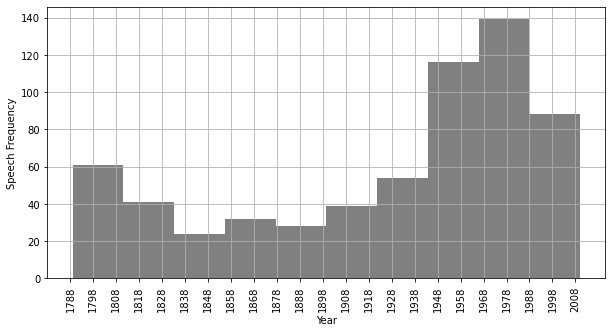

In [9]:

df['Year'].plot(kind='hist', figsize=(10,5),rot=90,grid=True,color ='gray')
plt.xticks(np.arange(1788,2011,10))

plt.xlabel("Year")
plt.ylabel('Speech Frequency')

plt.savefig("Frequency_of_Speech_Hist.png",dpi=300)
plt.show()

## Perform pre-processing of speech data:
1. Clean   
\w (word character) matches any single letter, number or underscore    
\s+       One or more spaces
2. Tokenize    
3. Lemmatize  

In [10]:
stemmer = WordNetLemmatizer()


def preprocess_speech(speech):
        # Remove all the special characters
        speech = re.sub(r'\W', ' ', str(speech))

        # remove all single characters
        speech = re.sub(r'\s+[a-zA-Z]\s+', ' ', speech)

        # Remove single characters from the start
        speech = re.sub(r'\^[a-zA-Z]\s+', ' ', speech)

        # Substituting multiple spaces with single space
        speech = re.sub(r'\s+', ' ', speech, flags=re.I)

        # Converting to Lowercase
        speech = speech.lower()

        # Token and Lemmatization
#         tokens = speech.split()
        tokens = word_tokenize(speech)
        tokens = [stemmer.lemmatize(word) for word in tokens]
        tokens = [word for word in tokens if word not in en_stop]
        tokens = [word for word in tokens if len(word)  > 2]

        return tokens

In [11]:
processed_speeches = []
for speech in speeches:
    tokens = preprocess_speech(speech)
    processed_speeches.append(tokens)


In [12]:
print("\n",date_of_speech[0],president_names[0],"\n",processed_speeches[0][0:100])
print("\n",date_of_speech[80],president_names[80],"\n",processed_speeches[80][0:100])
print("\n",date_of_speech[190],president_names[190],"\n",processed_speeches[190][0:100])


 1789-04-30 George Washington 
 ['fellow', 'citizen', 'senate', 'house', 'representative', 'among', 'vicissitude', 'incident', 'life', 'event', 'filled', 'greater', 'anxiety', 'notification', 'transmitted', 'order', 'received', 'fourteenth', 'day', 'present', 'month', 'hand', 'summoned', 'whose', 'voice', 'never', 'hear', 'veneration', 'love', 'retreat', 'chosen', 'fondest', 'predilection', 'flattering', 'hope', 'immutable', 'decision', 'asylum', 'declining', 'retreat', 'rendered', 'every', 'day', 'necessary', 'dear', 'addition', 'habit', 'inclination', 'frequent', 'interruption', 'health', 'gradual', 'waste', 'committed', 'hand', 'magnitude', 'difficulty', 'trust', 'voice', 'called', 'sufficient', 'awaken', 'wisest', 'experienced', 'citizen', 'distrustful', 'scrutiny', 'qualification', 'overwhelm', 'dispondence', 'inheriting', 'inferior', 'endowment', 'nature', 'unpractised', 'duty', 'civil', 'administration', 'ought', 'peculiarly', 'conscious', 'deficencies', 'conflict', 'emotion', 

<!-- ## Tokenize the words and removing the punctuations and unnecassary characters  -->
<!-- We will use Gensim's simple_preprocess() function for this task -->

# Topic modelling
###  LDA   
Term Document Freq: (word_id, word_frequency)

In [13]:
# Create Dictionary
id2word = corpora.Dictionary(processed_speeches)
# id2word.compactify()

# Create Corpus
texts = processed_speeches

# Term Document Frequency
corpus = [id2word.doc2bow(text,allow_update=True) for text in texts]


In [14]:
# View
print(id2word[0], "\n", corpus[0])

accomplished 
 [(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 2), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 2), (38, 1), (39, 1), (40, 2), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 2), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 2), (65, 1), (66, 2), (67, 1), (68, 1), (69, 1), (70, 1), (71, 3), (72, 5), (73, 1), (74, 1), (75, 1), (76, 1), (77, 1), (78, 2), (79, 1), (80, 1), (81, 1), (82, 1), (83, 1), (84, 2), (85, 1), (86, 1), (87, 1), (88, 1), (89, 1), (90, 1), (91, 1), (92, 1), (93, 1), (94, 1), (95, 1), (96, 1), (97, 1), (98, 1), (99, 1), (100, 1), (101, 1), (102, 1), (103, 1), (104, 2), (105, 2), (106, 1), (107, 1), (108, 1), (109

In [15]:
# Human readable format of corpus (term-frequency)
# [[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

### Build the topic model

In [16]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           update_every=1,
                                           passes=20)

In [17]:
# Print the Keyword in the 20 topics
topics = lda_model.print_topics(num_words=10)

for topic in topics:
    print(topic)

(0, '0.018*"war" + 0.008*"force" + 0.006*"peace" + 0.006*"day" + 0.005*"every" + 0.005*"enemy" + 0.005*"great" + 0.005*"military" + 0.005*"germany" + 0.005*"know"')
(1, '0.007*"peace" + 0.004*"israeli" + 0.003*"negotiation" + 0.003*"japanese" + 0.003*"two" + 0.003*"agreement" + 0.003*"night" + 0.003*"attacked" + 0.003*"israel" + 0.003*"leader"')
(2, '0.017*"president" + 0.016*"mondale" + 0.008*"think" + 0.008*"reagan" + 0.007*"budget" + 0.006*"know" + 0.005*"leadership" + 0.005*"deficit" + 0.005*"want" + 0.005*"walter"')
(3, '0.018*"university" + 0.010*"law" + 0.009*"educated" + 0.006*"court" + 0.006*"obligation" + 0.005*"citizen" + 0.005*"vanderbilt" + 0.004*"order" + 0.004*"judge" + 0.004*"mississippi"')
(4, '0.008*"berlin" + 0.007*"war" + 0.007*"europe" + 0.006*"freedom" + 0.006*"kosovo" + 0.006*"free" + 0.006*"peace" + 0.005*"polish" + 0.005*"ally" + 0.005*"city"')
(5, '0.010*"power" + 0.009*"constitution" + 0.008*"law" + 0.007*"right" + 0.006*"citizen" + 0.006*"every" + 0.005*"war

In [18]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_speeches, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.31411844493157

Coherence Score:  0.39912774945263924


# Visualize the topics

In [19]:
# Visualize the topics
import pyLDAvis
import pyLDAvis.gensim  # don't skip this

pyLDAvis.enable_notebook(local=False)


D:\anaconda3\lib\site-packages\sklearn\decomposition\_lda.py:28: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps


In [20]:
lda_visualization = pyLDAvis.gensim.prepare(lda_model, corpus, id2word, sort_topics=False)
pyLDAvis.display(lda_visualization)

D:\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Optimize the number of topics

In [21]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=2):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    perplexity : Perplexity Values
    
    As a rule of thumb for a good LDA model, the perplexity score should be low while coherence should be high. 
    The Gensim library has a CoherenceModel class which can be used to find the coherence of LDA model. 
    For perplexity, the LdaModel object contains log_perplexity method which takes a bag of words corpus as a 
    parameter and returns the corresponding perplexity.
    
    """
    coherence_values = []
    model_list = []
    perplexity= []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                           id2word=dictionary,
                                                           num_topics=num_topics, 
                                                           update_every=1,
                                                           passes=20)        
        
        model_list.append(model)
        perplexity.append(model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values, perplexity

D:\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [22]:
# Can take a long time to run.
model_list, coherence_values, perplexity = compute_coherence_values(dictionary=id2word, \
                                                        corpus=corpus, texts=processed_speeches, start=12, limit=30, step=4)

D:\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


D:\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


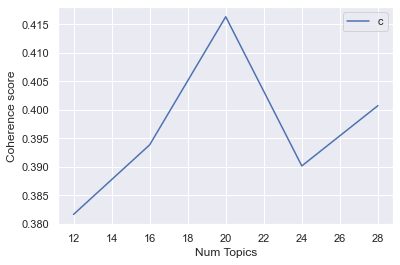

In [32]:
import seaborn as sns
sns.set()
# Show graph for coherence_values
limit=30; start=12; step=4;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')

plt.savefig("Coherence_value.png",dpi=300)
plt.show()

D:\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


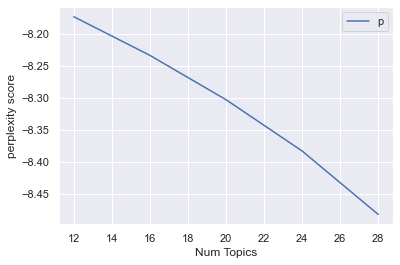

In [33]:
# Show graph for perplexity
limit=30; start=12; step=4;
x = range(start, limit, step)
plt.plot(x, perplexity)
plt.xlabel("Num Topics")
plt.ylabel("perplexity score")
plt.legend(("perplexity"), loc='best')

plt.savefig("Perplexity_value.png",dpi=300)
plt.show()

In [25]:
iterations = 0
for p, cv, i in zip(perplexity, coherence_values, x):
    print("Iteration: ", iterations, ", Number of Topics : ", i, ", Perplexity: ", p, ", CV Score: ", cv, "\n")
    iterations +=1
    

Iteration:  0 , Number of Topics :  12 , Perplexity:  -8.173333615138173 , CV Score:  0.38161900902974294 

Iteration:  1 , Number of Topics :  16 , Perplexity:  -8.233685586363924 , CV Score:  0.3938397024733348 

Iteration:  2 , Number of Topics :  20 , Perplexity:  -8.302931345377782 , CV Score:  0.41635936312965727 

Iteration:  3 , Number of Topics :  24 , Perplexity:  -8.383038950994706 , CV Score:  0.390141997481493 

Iteration:  4 , Number of Topics :  28 , Perplexity:  -8.482149006531754 , CV Score:  0.4007329663087789 



D:\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Print the topic and words in those topic for Best model i.e topic count = 20

In [ ]:
model_list

In [27]:
x=model_list[2].show_topics(num_topics=20, num_words=15,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

topics=[]
top_words=[]
#Below Code Prints Topics and Words
for topic,words in topics_words:
    print(str(topic)+ "::"+ str(words),"\n")
    topics.append(topic)
    top_words.append(words)
print()

# #Below Code Prints Only Words 
# for topic,words in topics_words:
#     print(" ".join(words))

0::['clay', 'question', 'life', 'great', 'disability', 'slavery', 'henry', 'never', 'day', 'liberty', 'governor', 'detroit', 'friend', 'missouri', 'without'] 

1::['slavery', 'territory', 'slave', 'constitution', 'missouri', 'kansa', 'law', 'principle', 'compromise', 'party', 'free', 'question', 'line', 'north', 'without'] 

2::['tree', 'oklahoma', 'keating', 'spinning', 'weaving', 'clothes', 'grief', 'paralyze', 'admonished', 'dogwood', 'heroically', 'psalm', 'wither', 'pta', 'righteousness'] 

3::['made', 'great', 'treaty', 'citizen', 'last', 'interest', 'power', 'subject', 'law', 'part', 'duty', 'act', 'present', 'war', 'relation'] 

4::['tax', 'federal', 'billion', 'energy', 'economic', 'budget', 'price', 'inflation', 'know', 'increase', 'work', 'problem', 'job', 'last', 'president'] 

5::['expedition', 'enterprise', 'pierce', 'franklin', 'offender', 'unlawful', 'criminal', 'penalty', 'friendly', 'law', 'exhort', 'marcy', 'discountenance', 'unmindful', '1854'] 

6::['president', 't

D:\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# topic_map = {0:'Slavery/Human Rights',1:'Slavery/Human Rights',
#             2:'Law & Order', 3:'Administration',
#             4:'Budget/Economy', 5:'Law & Order',
#             6:'Russia Cold War', 7:'War/Duty',
#             8:'Slavery/Human Rights',9:'Labour/Economy',
#             10:'Law & Order/Constitution',11:'Cold War/Russia/Vietnam',
#             12:'War/Iraq',13:'War/Vietnam' ,
#             14:'War/Future',15:'Family/Employment',
#             16:'Economy/Tax', 17:'War/Germany',
#             18:'Economy',
#             19:'Scandal/Conspiracy'}    

# for i in topics:
#     print("Topic:",i,":",topic_map[i],":",top_words[i],"\n")

In [28]:
# # Visualize the topics
import pyLDAvis
import pyLDAvis.gensim  # don't skip this

pyLDAvis.enable_notebook(local=False)

D:\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [29]:
lda_visualization = pyLDAvis.gensim.prepare(model_list[2], corpus, id2word, sort_topics=False)
pyLDAvis.display(lda_visualization)

D:\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [31]:
pyLDAvis.save_html(lda_visualization,'lda_topicModelling.html')

D:\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Evaluation of Model

In [ ]:
# for i, speech in zip(range(5), processed_speeches):
#     test_doc = speech
# #     test_doc = preprocess_speech(test_doc)
#     bow_test_doc = id2word.doc2bow(test_doc)
#     topic_prob =  model_list[4].get_document_topics(bow_test_doc)
    
#     print("\n Topic for speech",i+1, " is : ",topic_prob)
#     print( max(topic_prob,key=lambda item:item[1])[0])
#     print( max(topic_prob,key=lambda item:item[1])[1])

In [ ]:
# topic = []
# probability= []
# topic_words = []
# topic_name = []
# for speech in processed_speeches:
#     test_doc = speech
# #     test_doc = preprocess_speech(test_doc)
#     bow_test_doc = id2word.doc2bow(test_doc)
#     topic_prob =  model_list[4].get_document_topics(bow_test_doc)
    
#     topic_number = max(topic_prob,key=lambda item:item[1])[0]
#     confidence = round(max(topic_prob,key=lambda item:item[1])[1]*100,2)
#     topic.append(topic_number)
#     topic_name.append(topic_map[topic_number])
#     probability.append(confidence)
#     topic_words.append(topics_words[topic_number][1])
    

In [ ]:
# df['Topic'] = pd.Series(topic)
# df['Topic_Name'] = pd.Series(topic_name)
# df['Probability'] = pd.Series(probability)
# df['Topic_Words'] = pd.Series(topic_words)

# df.sample(5)


In [ ]:
# df.to_excel("save_data.xlsx")

In [ ]:
# import seaborn as sns
# sns.set()

# df['Topic'].plot(kind='hist', figsize=(10,5))
# plt.xticks(np.arange(0,26,1))

# plt.xlabel("Topic")
# plt.ylabel('Speeches')

# plt.savefig("Topic_Hist.png",dpi=300)
# plt.show()

In [ ]:

# plt.figure(figsize=(15,10))
# plt.xticks(np.arange(0,26,1))
# sns.scatterplot(data=df, x="Topic", y="Name", hue="Topic",palette="deep",legend=False,size='Name')

# plt.savefig("President_Topic.png",dpi=300)
# plt.show()

In [ ]:
# plt.figure(figsize=(15,8))
# # plt.xticks(np.arange(0,26,1))
# sns.scatterplot(data=df, y="Topic", x="Year", hue="Topic",palette="deep",legend=False)

# plt.savefig("Year_Topic.png",dpi=300)
# plt.show()